# Spin Postprocessing
Apply postprocessing to the rotation center on the surface

In [103]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast

Import video

In [104]:
video_number = "3"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 227.0


Import data

In [105]:
# Define the path to the CSV file
input_data_path = project_root / "notebook" / "spin" / "intermediate_data" / f"Ball_data_{video_number}.csv"

# Load the CSV file into a DataFrame
ball_df = pd.read_csv(input_data_path)
print(ball_df.head())

   frame   x   y  radius  rotation_center_x  rotation_center_y
0      0 NaN NaN     NaN                NaN                NaN
1      1 NaN NaN     NaN                NaN                NaN
2      2 NaN NaN     NaN                NaN                NaN
3      3 NaN NaN     NaN                NaN                NaN
4      4 NaN NaN     NaN                NaN                NaN


Postprocessing

In [106]:
# Ensure that both 'rotation_center_x' and 'rotation_center_y' columns exist and have valid values
if 'rotation_center_x' in ball_df.columns and 'rotation_center_y' in ball_df.columns:
    # Drop rows with missing values in the relevant columns
    valid_data = ball_df.dropna(subset=['rotation_center_x', 'rotation_center_y'])
    
    # Compute the distances between consecutive points
    distances = np.sqrt(
        (np.diff(valid_data['rotation_center_x']-valid_data['x']) ** 2) +
        (np.diff(valid_data['rotation_center_y']-valid_data['y']) ** 2)
    )

    # Add 0 as the first element of distances
    distances = np.insert(distances, 0, 0)

    # Add the distances as a new column to the DataFrame
    valid_data['distance'] = distances

    print(valid_data[['rotation_center_x', 'rotation_center_y', 'distance']])
else:
    print("The required columns 'rotation_center_x' and 'rotation_center_y' are not present in the DataFrame.")

     rotation_center_x  rotation_center_y   distance
32          809.979183         950.123928   0.000000
33          832.945448         872.831232  74.034826
38          852.368992         847.319605  34.176866
39          895.136315         809.645220  44.618653
40          896.098911         800.776707   4.448817
..                 ...                ...        ...
185        1258.645651         456.956318  56.459667
186        1232.632618         493.531080  47.953326
187        1269.905059         458.420481  48.354247
188        1193.798460         474.501489  44.787908
191        1208.280350         472.486552   5.291907

[137 rows x 3 columns]


C:\Users\miche\AppData\Local\Temp\ipykernel_18244\4288155829.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['distance'] = distances


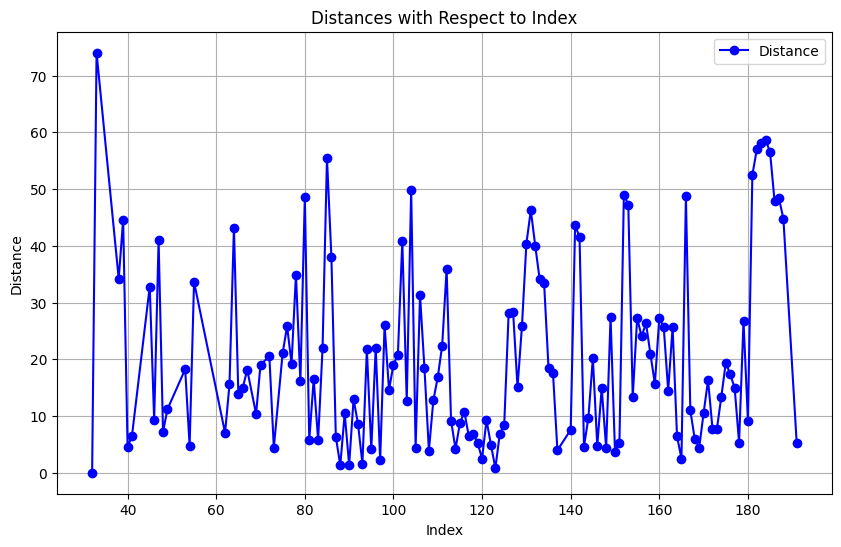

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(valid_data.index, valid_data['distance'], marker='o', linestyle='-', color='b', label='Distance')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Distances with Respect to Index')
plt.legend()
plt.grid()
plt.show()

Outliers removal

In [108]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = valid_data['distance'].quantile(0.25)
Q3 = valid_data['distance'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR

# Filter out the outliers
valid_data_filtered = valid_data[(valid_data['distance'] >= lower_bound) & (valid_data['distance'] <= upper_bound)]

print(valid_data_filtered[['rotation_center_x', 'rotation_center_y', 'distance']])

     rotation_center_x  rotation_center_y   distance
32          809.979183         950.123928   0.000000
38          852.368992         847.319605  34.176866
40          896.098911         800.776707   4.448817
41          898.912536         797.958435   6.556981
45          908.420444         784.882829  32.823866
..                 ...                ...        ...
177        1219.351380         486.146309  14.960643
178        1221.316103         480.226700   5.323994
179        1218.399475         506.652102  26.714075
180        1216.201246         499.045022   9.182074
191        1208.280350         472.486552   5.291907

[113 rows x 3 columns]


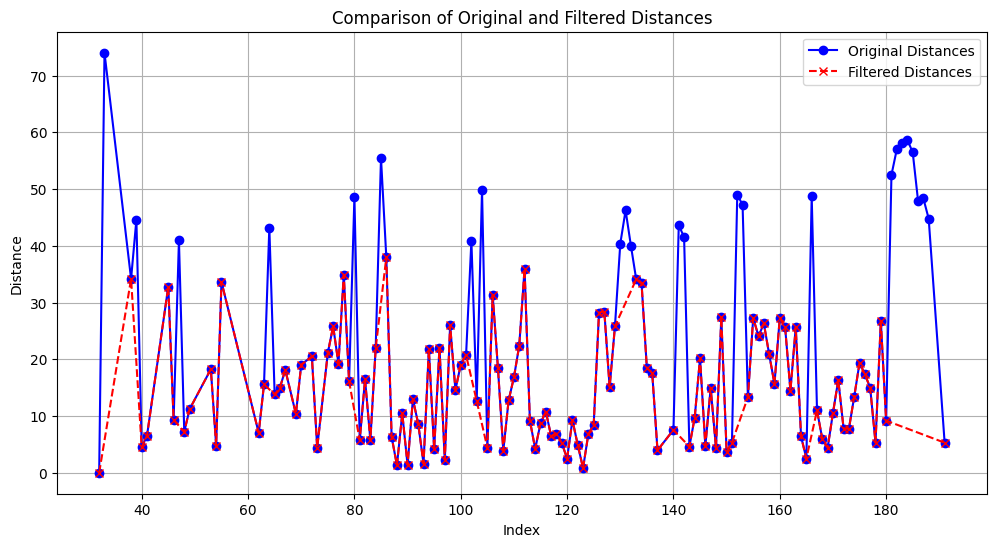

In [109]:
plt.figure(figsize=(12, 6))

# Plot old distances
plt.plot(valid_data.index, valid_data['distance'], marker='o', linestyle='-', color='b', label='Original Distances')

# Plot new distances (filtered)
plt.plot(valid_data_filtered.index, valid_data_filtered['distance'], marker='x', linestyle='--', color='r', label='Filtered Distances')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Comparison of Original and Filtered Distances')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Interpolate missing coordinates

In [110]:
# Reindex to include all missing indexes within the range
valid_data_filtered = valid_data_filtered.reindex(range(valid_data_filtered.index.min(), valid_data_filtered.index.max() + 1))

# Interpolate missing values for 'distance' and other columns
valid_data_filtered['distance'] = valid_data_filtered['distance'].interpolate(method='linear')
valid_data_filtered['rotation_center_x'] = valid_data_filtered['rotation_center_x'].interpolate(method='linear')
valid_data_filtered['rotation_center_y'] = valid_data_filtered['rotation_center_y'].interpolate(method='linear')

# Print the updated DataFrame
print(valid_data_filtered[['rotation_center_x', 'rotation_center_y', 'distance']])

     rotation_center_x  rotation_center_y   distance
32          809.979183         950.123928   0.000000
33          817.044151         932.989874   5.696144
34          824.109119         915.855820  11.392289
35          831.174088         898.721766  17.088433
36          838.239056         881.587713  22.784577
..                 ...                ...        ...
187        1211.160676         482.144178   6.706513
188        1210.440594         479.729771   6.352862
189        1209.720513         477.315365   5.999210
190        1209.000431         474.900959   5.645559
191        1208.280350         472.486552   5.291907

[160 rows x 3 columns]


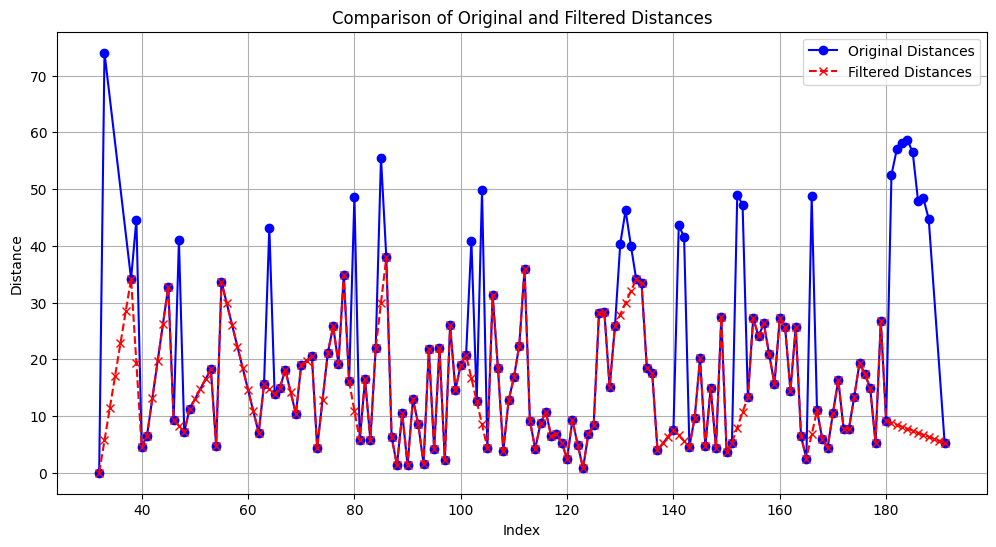

In [111]:
plt.figure(figsize=(12, 6))

# Plot original distances
plt.plot(valid_data.index, valid_data['distance'], marker='o', linestyle='-', color='b', label='Original Distances')

# Plot filtered distances
plt.plot(valid_data_filtered.index, valid_data_filtered['distance'], marker='x', linestyle='--', color='r', label='Filtered Distances')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Comparison of Original and Filtered Distances')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Median filter

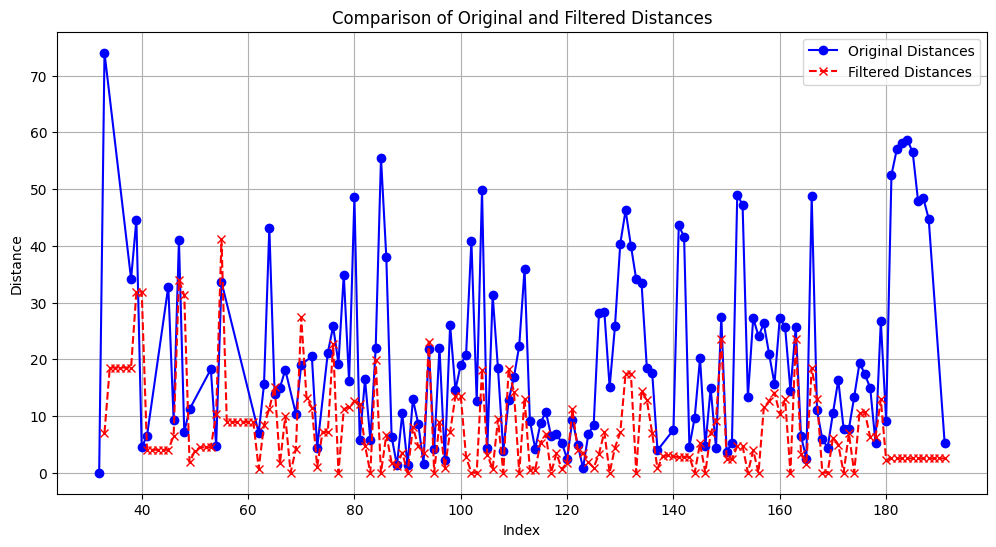

In [112]:
# Apply median filter to 'rotation_center_x' and 'rotation_center_y'
valid_data_filtered['rotation_center_x'] = medfilt(valid_data_filtered['rotation_center_x'], kernel_size=3)
valid_data_filtered['rotation_center_y'] = medfilt(valid_data_filtered['rotation_center_y'], kernel_size=3)
# Compute the new distances between consecutive points after applying the median filter
valid_data_filtered['distance'] = np.sqrt(
    valid_data_filtered['rotation_center_x'].diff() ** 2 +
    valid_data_filtered['rotation_center_y'].diff() ** 2
)
# Print the updated DataFrame
# print(valid_data_filtered[['rotation_center_x', 'rotation_center_y']])

plt.figure(figsize=(12, 6))

# Plot distances before applying the median filter
plt.plot(valid_data.index, valid_data['distance'], marker='o', linestyle='-', color='b', label='Original Distances')

# Plot distances after applying the median filter
plt.plot(valid_data_filtered.index, valid_data_filtered['distance'], marker='x', linestyle='--', color='r', label='Filtered Distances')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Comparison of Original and Filtered Distances')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Outliers removal + interpolation

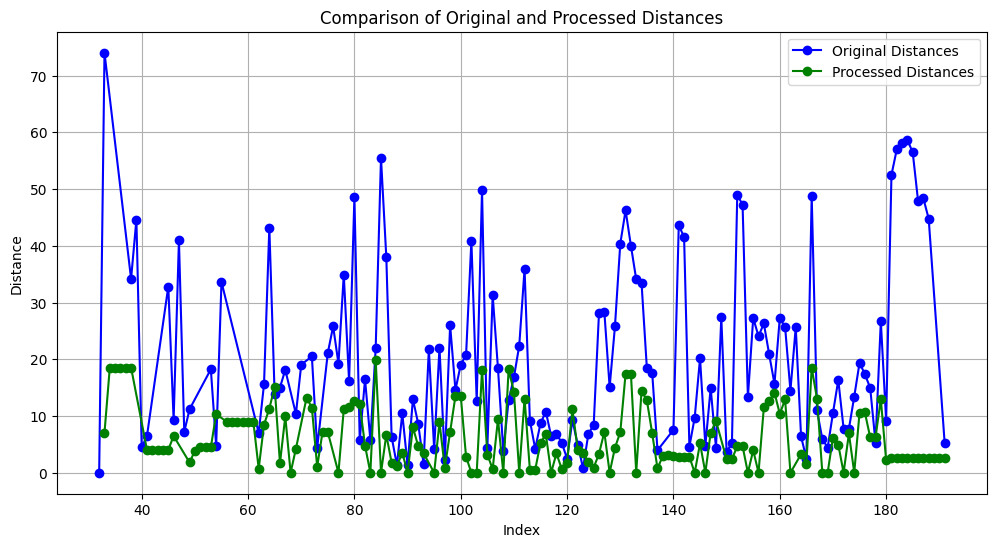

In [113]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = valid_data_filtered['distance'].quantile(0.25)
Q3 = valid_data_filtered['distance'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1 * IQR
upper_bound = Q3 + 1 * IQR

# Remove outliers from the 'distances' column in the filtered data
valid_data_filtered = valid_data_filtered[
    (valid_data_filtered['distance'] >= lower_bound) & 
    (valid_data_filtered['distance'] <= upper_bound)
]

# Interpolate missing values for 'distance' and other columns
valid_data_filtered['distance'] = valid_data_filtered['distance'].interpolate(method='linear')
valid_data_filtered['rotation_center_x'] = valid_data_filtered['rotation_center_x'].interpolate(method='linear')
valid_data_filtered['rotation_center_y'] = valid_data_filtered['rotation_center_y'].interpolate(method='linear')

plt.figure(figsize=(12, 6))

# Plot original distances
plt.plot(valid_data.index, valid_data['distance'], marker='o', linestyle='-', color='b', label='Original Distances')

# Plot distances after removing outliers and interpolating
plt.plot(valid_data_filtered.index, valid_data_filtered['distance'], marker='o', linestyle='-', color='g', label='Processed Distances')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Comparison of Original and Processed Distances')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Smoothing

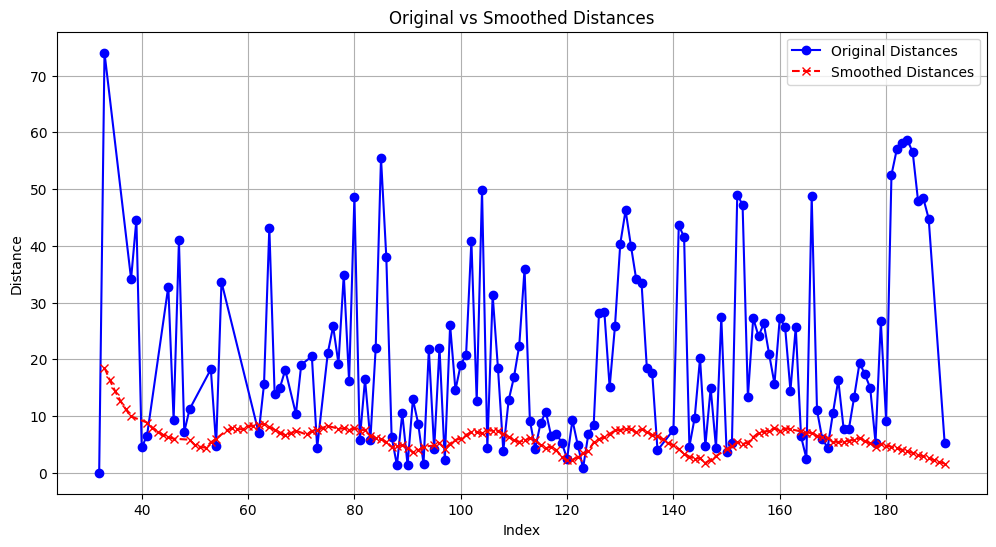

In [114]:
# Apply Savitzky-Golay filter for smoothing
valid_data_filtered['distance'] = savgol_filter(valid_data_filtered['distance'], window_length=25, polyorder=3)
valid_data_filtered['rotation_center_x'] = savgol_filter(valid_data_filtered['rotation_center_x'], window_length=25, polyorder=3)
valid_data_filtered['rotation_center_y'] = savgol_filter(valid_data_filtered['rotation_center_y'], window_length=25, polyorder=3)
# Plot the original and smoothed distances
plt.figure(figsize=(12, 6))

# Plot original distances
plt.plot(valid_data.index, valid_data['distance'], marker='o', linestyle='-', color='b', label='Original Distances')

# Plot smoothed distances
plt.plot(valid_data_filtered.index, valid_data_filtered['distance'], marker='x', linestyle='--', color='r', label='Smoothed Distances')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Distance')
plt.title('Original vs Smoothed Distances')
plt.legend()
plt.grid()

# Show the plot
plt.show()

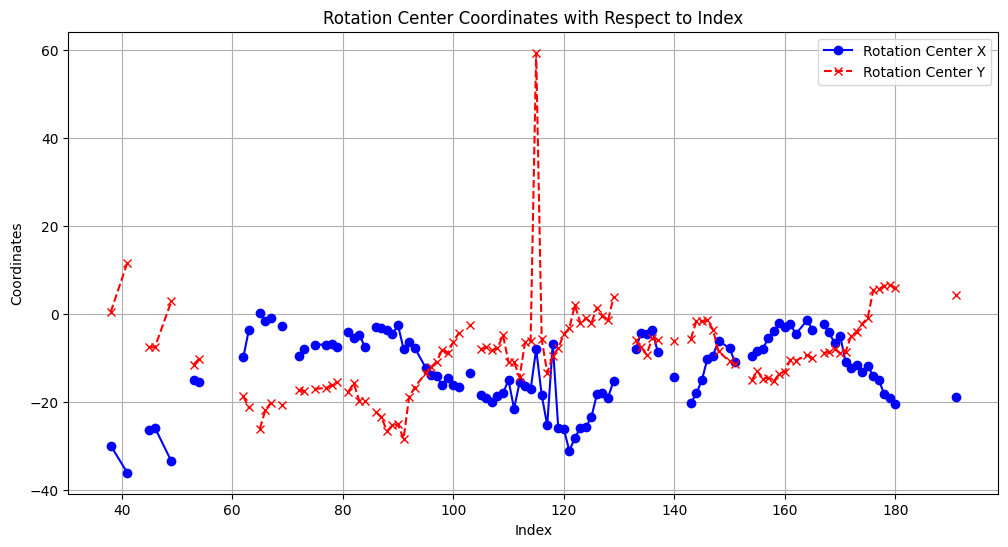

In [115]:
plt.figure(figsize=(12, 6))

# Plot rotation center x coordinates
plt.plot(valid_data_filtered.index, valid_data_filtered['rotation_center_x']-valid_data_filtered['x'], marker='o', linestyle='-', color='b', label='Rotation Center X')

# Plot rotation center y coordinates
plt.plot(valid_data_filtered.index, valid_data_filtered['rotation_center_y']-valid_data_filtered['y'], marker='x', linestyle='--', color='r', label='Rotation Center Y')

# Add labels, title, and legend
plt.xlabel('Index')
plt.ylabel('Coordinates')
plt.title('Rotation Center Coordinates with Respect to Index')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Generate video

In [116]:
output_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"spin_video_processed_{video_number}.mp4"

# Ottieni le proprietà del video originale
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Inizializza il VideoWriter
out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

# Riposiziona il video all'inizio
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Itera su tutti i frame del video
frame_idx = 0
while True:
# for i in range(151):
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the current frame index exists in valid_data_filtered
    if frame_idx in valid_data_filtered.index:
        # Get the row corresponding to the current frame index
        row = valid_data_filtered.loc[frame_idx]

        # Draw the ball center if x and y are not NaN
        if not math.isnan(ball_df.iloc[frame_idx]['x']) and not math.isnan(ball_df.iloc[frame_idx]['y']):
            center = (int(ball_df.iloc[frame_idx]['x']), int(ball_df.iloc[frame_idx]['y']))
            cv2.circle(frame, center, 5, (255, 0, 0), -1) 

        # Draw the rotation center if rotation_center_x and rotation_center_y are not NaN
        if not math.isnan(row['rotation_center_x']) and not math.isnan(row['rotation_center_y']):
            rotation_center = (int(row['rotation_center_x']), int(row['rotation_center_y']))
            cv2.circle(frame, rotation_center, 5, (0, 255, 255), -1)  

    # Scrivi il frame nel video di output
    out.write(frame)

    # Incrementa l'indice del frame
    frame_idx += 1

# Rilascia le risorse
out.release()

print(f"Video annotato salvato in: {output_video_path}")

Video annotato salvato in: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_3\test_video\spin_video_processed_3.mp4


In [117]:
# Define the output path for the cropped video
cropped_ball_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"spin_video_ball_cropped_{video_number}.mp4"

crop_size = 80

# Initialize the VideoWriter for the cropped video
cropped_ball_out = cv2.VideoWriter(str(cropped_ball_video_path), fourcc, fps, (2 * crop_size, 2 * crop_size))

# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Iterate through all frames of the video
frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the current frame index exists in ball_df
    if frame_idx in valid_data_filtered.index:
        # Get the row corresponding to the current frame index
        row = ball_df.iloc[frame_idx]

        # Ensure the ball center coordinates and radius are valid
        if not math.isnan(row['x']) and not math.isnan(row['y']) and not math.isnan(row['radius']):
            center_x = int(row['x'])
            center_y = int(row['y'])
            radius = crop_size

            # Define the cropping region
            x_start = max(center_x - radius, 0)
            y_start = max(center_y - radius, 0)
            x_end = min(center_x + radius, frame_width)
            y_end = min(center_y + radius, frame_height)

            # Crop the frame
            cropped_frame = frame[y_start:y_end, x_start:x_end]
            # Draw the ball center if x and y are not NaN
            cv2.circle(cropped_frame, (crop_size, crop_size), 5, (255, 0, 0), -1)

            # Draw the rotation center if rotation_center_x and rotation_center_y are not NaN
            if not math.isnan(valid_data_filtered.loc[frame_idx]['rotation_center_x']) and not math.isnan(valid_data_filtered.loc[frame_idx]['rotation_center_y']):
                rotation_center_x = int(valid_data_filtered.loc[frame_idx]['rotation_center_x']) - x_start
                rotation_center_y = int(valid_data_filtered.loc[frame_idx]['rotation_center_y']) - y_start
                if 0 <= rotation_center_x < cropped_frame.shape[1] and 0 <= rotation_center_y < cropped_frame.shape[0]:
                    cv2.circle(cropped_frame, (rotation_center_x, rotation_center_y), 5, (0, 255, 255), -1)
            # Write the cropped frame to the output video
            cropped_ball_out.write(cropped_frame)

    # Increment the frame index
    frame_idx += 1

# Release resources
cropped_ball_out.release()

print(f"Cropped ball video saved at: {cropped_ball_video_path}")


Cropped ball video saved at: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_3\test_video\spin_video_ball_cropped_3.mp4
